In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance
from pandas import read_gbq
import datetime
import pytz

In [8]:
# df = read_gbq(f"""

# SELECT *
# FROM capstone-402105.capstone.cri_compustat_data

# """,project_id='capstone-402105', dialect='standard')

df = pd.read_pickle('cri_compustat_data.pkl')

In [9]:
df.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'StartDate',
       'EventDate', 'Default_1', 'Default_3', 'Default_6', 'Default_12',
       'Default_24', 'Default_36', 'Default_60', 'Duration', 'gvkey', 'tic',
       'current_ratio', 'quick_ratio', 'cash_ratio', 'net_working_capital',
       'debt_ratio', 'debt_to_equity_ratio', 'equity_ratio',
       'cashflow_to_debt_ratio', 'net_profit_margin', 'return_on_assets',
       'asset_turnover', 'inventory_turnover', 'days_in_inventory',
       'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 

In [20]:
cols = list(df.columns)

df.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
date2020 = datetime.datetime(2020,1,1).replace(tzinfo=pytz.UTC)
train_df = df[df["EventDate"] < date2020]
validation_df = df[(df["EventDate"] >= date2020) & (df["EventDate"] < date2022)]
test_df = df[df["EventDate"] >= date2022]

In [21]:
x_train = train_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_train = train_df['Default_12']
x_validation = validation_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_validation = validation_df['Default_12']
x_test = test_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_test = test_df["Default_12"]

In [24]:
x_train.columns

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'DTDmedianNonFin', 'current_ratio', 'quick_ratio', 'cash_ratio',
       'net_working_capital', 'debt_ratio', 'debt_to_equity_ratio',
       'equity_ratio', 'cashflow_to_debt_ratio', 'net_profit_margin',
       'return_on_assets', 'asset_turnover', 'inventory_turnover',
       'days_in_inventory', 'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio'],
      dtype='object')

In [25]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_validation.shape, y_validation.shape

((1084578, 40), (1084578,), (36537, 40), (36537,), (58299, 40), (58299,))

In [26]:
# mini sample to try:
msk = np.random.rand(len(x_train)) < 0.0001
x_train_sample=x_train[msk]
y_train_sample=y_train[msk]

In [28]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'auc', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-08 09:35:24,474] A new study created in memory with name: no-name-fee480ad-e67d-4bd0-a58a-0b5f869e8d8f


c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 09:35:46,886] Trial 0 finished with value: 0.9620412803228883 and parameters: {'num_leaves': 149, 'lambda_l1': 4.693279291035415e-07, 'lambda_l2': 0.00022563013409191595, 'feature_fraction': 0.5268082498440785, 'min_child_samples': 52, 'learning_rate': 8.936394438796985e-05, 'max_depth': 212, 'num_boost_round': 217}. Best is trial 0 with value: 0.9620412803228883.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:36:23,173] Trial 1 finished with value: 0.8561957924376349 and parameters: {'num_leaves': 160, 'lambda_l1': 0.002922874793149595, 'lambda_l2': 0.00011101700556197347, 'feature_fraction': 0.8961690143624079, 'min_child_samples': 9, 'learning_rate': 0.19937152731654845, 'max_depth': 234, 'num_boost_round': 348}. Best is trial 0 with value: 0.9620412803228883.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:37:07,084] Trial 2 finished with value: 0.9654908127807867 and parameters: {'num_leaves': 183, 'lambda_l1': 4.565179697742477, 'lambda_l2': 3.2957354044561866e-05, 'feature_fraction': 0.5084700723901019, 'min_child_samples': 86, 'learning_rate': 0.0031817486223309757, 'max_depth': 242, 'num_boost_round': 375}. Best is trial 2 with value: 0.9654908127807867.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 09:37:20,469] Trial 3 finished with value: 0.9614694737021349 and parameters: {'num_leaves': 106, 'lambda_l1': 1.4489299080102343e-08, 'lambda_l2': 1.683541561291074e-05, 'feature_fraction': 0.4672458661485208, 'min_child_samples': 90, 'learning_rate': 0.0020552030609199395, 'max_depth': 83, 'num_boost_round': 102}. Best is trial 2 with value: 0.9654908127807867.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 09:38:17,587] Trial 4 finished with value: 0.9619010166008938 and parameters: {'num_leaves': 256, 'lambda_l1': 5.24275824430779e-05, 'lambda_l2': 2.184144564056344e-07, 'feature_fraction': 0.850487491977951, 'min_child_samples': 98, 'learning_rate': 0.00019346566034725027, 'max_depth': 41, 'num_boost_round': 324}. Best is trial 2 with value: 0.9654908127807867.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 09:38:55,418] Trial 5 finished with value: 0.9610642370734155 and parameters: {'num_leaves': 144, 'lambda_l1': 7.790084929860763, 'lambda_l2': 0.0037140591105808253, 'feature_fraction': 0.512141204970811, 'min_child_samples': 13, 'learning_rate': 0.0002627125248547476, 'max_depth': 90, 'num_boost_round': 327}. Best is trial 2 with value: 0.9654908127807867.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 09:39:09,391] Trial 6 finished with value: 0.957197706573533 and parameters: {'num_leaves': 102, 'lambda_l1': 1.5530062296198135e-08, 'lambda_l2': 3.112734097882635e-06, 'feature_fraction': 0.7095616864302126, 'min_child_samples': 30, 'learning_rate': 1.4248349523248548e-06, 'max_depth': 33, 'num_boost_round': 116}. Best is trial 2 with value: 0.9654908127807867.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 09:39:17,936] Trial 7 finished with value: 0.5 and parameters: {'num_leaves': 18, 'lambda_l1': 4.961515669680454e-05, 'lambda_l2': 3.379219552089955e-05, 'feature_fraction': 0.8460331009688207, 'min_child_samples': 68, 'learning_rate': 5.760617494688596, 'max_depth': 70, 'num_boost_round': 176}. Best is trial 2 with value: 0.9654908127807867.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 09:39:31,840] Trial 8 finished with value: 0.9495563627663018 and parameters: {'num_leaves': 17, 'lambda_l1': 0.2157983329585988, 'lambda_l2': 0.003823431080304342, 'feature_fraction': 0.6938317798649432, 'min_child_samples': 61, 'learning_rate': 2.4964731087987998e-08, 'max_depth': 58, 'num_boost_round': 169}. Best is trial 2 with value: 0.9654908127807867.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 09:39:39,106] Trial 9 finished with value: 0.9402099142109964 and parameters: {'num_leaves': 160, 'lambda_l1': 0.0017521657173876532, 'lambda_l2': 0.032428986964586175, 'feature_fraction': 0.5974270443717402, 'min_child_samples': 56, 'learning_rate': 9.833942252345027e-08, 'max_depth': 2, 'num_boost_round': 208}. Best is trial 2 with value: 0.9654908127807867.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:40:34,202] Trial 10 finished with value: 0.973687016949752 and parameters: {'num_leaves': 231, 'lambda_l1': 9.451065276773114, 'lambda_l2': 2.7129651328580113, 'feature_fraction': 0.4052585654714172, 'min_child_samples': 79, 'learning_rate': 0.016140327479645583, 'max_depth': 171, 'num_boost_round': 475}. Best is trial 10 with value: 0.973687016949752.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:41:29,714] Trial 11 finished with value: 0.9743695063830363 and parameters: {'num_leaves': 239, 'lambda_l1': 7.114876090836347, 'lambda_l2': 0.9453601931173993, 'feature_fraction': 0.40910125266104075, 'min_child_samples': 77, 'learning_rate': 0.020808262381792262, 'max_depth': 171, 'num_boost_round': 473}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:42:29,798] Trial 12 finished with value: 0.9708733921793314 and parameters: {'num_leaves': 253, 'lambda_l1': 0.19992416815124606, 'lambda_l2': 9.807011248819013, 'feature_fraction': 0.42979784174594854, 'min_child_samples': 75, 'learning_rate': 0.06371896663098284, 'max_depth': 172, 'num_boost_round': 498}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:43:14,856] Trial 13 finished with value: 0.9696975783168222 and parameters: {'num_leaves': 215, 'lambda_l1': 0.4474912000235277, 'lambda_l2': 8.799324796771915, 'feature_fraction': 0.4039217838454231, 'min_child_samples': 43, 'learning_rate': 0.06438493200966629, 'max_depth': 157, 'num_boost_round': 478}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-08 09:43:31,649] Trial 14 finished with value: 0.7475260644924954 and parameters: {'num_leaves': 216, 'lambda_l1': 9.140855618148754, 'lambda_l2': 0.4425027091855263, 'feature_fraction': 0.40134486463238706, 'min_child_samples': 77, 'learning_rate': 2.729935672720006, 'max_depth': 130, 'num_boost_round': 423}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:44:29,134] Trial 15 finished with value: 0.9706849639691424 and parameters: {'num_leaves': 209, 'lambda_l1': 0.01614455300417613, 'lambda_l2': 0.3363067234285346, 'feature_fraction': 0.5743276972283561, 'min_child_samples': 79, 'learning_rate': 0.006550149007172715, 'max_depth': 181, 'num_boost_round': 436}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:45:01,409] Trial 16 finished with value: 0.743630444279063 and parameters: {'num_leaves': 73, 'lambda_l1': 0.8525153025932133, 'lambda_l2': 0.8067361743909889, 'feature_fraction': 0.4714162821051428, 'min_child_samples': 100, 'learning_rate': 0.41446760388353726, 'max_depth': 120, 'num_boost_round': 418}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 09:45:32,009] Trial 17 finished with value: 0.9631086763318013 and parameters: {'num_leaves': 232, 'lambda_l1': 0.04885415314825881, 'lambda_l2': 0.0309240955641791, 'feature_fraction': 0.5930449851099536, 'min_child_samples': 67, 'learning_rate': 2.156955999863209e-05, 'max_depth': 202, 'num_boost_round': 263}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:46:16,759] Trial 18 finished with value: 0.9698679141441938 and parameters: {'num_leaves': 183, 'lambda_l1': 1.4156706521387084, 'lambda_l2': 0.001857570892843089, 'feature_fraction': 0.4042402597091716, 'min_child_samples': 43, 'learning_rate': 0.006540050843364894, 'max_depth': 130, 'num_boost_round': 457}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:47:33,150] Trial 19 finished with value: 0.9717262174399873 and parameters: {'num_leaves': 190, 'lambda_l1': 0.06712666544964421, 'lambda_l2': 1.7747463759009525, 'feature_fraction': 0.9903421152394281, 'min_child_samples': 89, 'learning_rate': 0.024921476794846492, 'max_depth': 153, 'num_boost_round': 389}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 09:48:02,230] Trial 20 finished with value: 0.9586888136352493 and parameters: {'num_leaves': 54, 'lambda_l1': 1.6538445834538473, 'lambda_l2': 0.0573251129148133, 'feature_fraction': 0.46646695974708263, 'min_child_samples': 70, 'learning_rate': 0.0008524800328128481, 'max_depth': 206, 'num_boost_round': 289}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:49:12,930] Trial 21 finished with value: 0.9725911042891882 and parameters: {'num_leaves': 187, 'lambda_l1': 8.511333140797179, 'lambda_l2': 2.9049980784017784, 'feature_fraction': 0.9840856607958441, 'min_child_samples': 87, 'learning_rate': 0.02345889637693435, 'max_depth': 156, 'num_boost_round': 397}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:50:08,248] Trial 22 finished with value: 0.6045715985719954 and parameters: {'num_leaves': 241, 'lambda_l1': 5.638973253109177, 'lambda_l2': 2.5797389060746125, 'feature_fraction': 0.6745440981504383, 'min_child_samples': 85, 'learning_rate': 0.4740706007958364, 'max_depth': 108, 'num_boost_round': 461}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:51:11,705] Trial 23 finished with value: 0.9721916528567844 and parameters: {'num_leaves': 199, 'lambda_l1': 0.809091804965892, 'lambda_l2': 0.1339484131181123, 'feature_fraction': 0.762466085118505, 'min_child_samples': 94, 'learning_rate': 0.012640600502107765, 'max_depth': 183, 'num_boost_round': 389}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:52:13,475] Trial 24 finished with value: 0.9722347143652101 and parameters: {'num_leaves': 232, 'lambda_l1': 1.6945255301266489, 'lambda_l2': 1.916705473402339, 'feature_fraction': 0.6381158730271199, 'min_child_samples': 81, 'learning_rate': 0.029198409261661645, 'max_depth': 147, 'num_boost_round': 499}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:53:08,976] Trial 25 finished with value: 0.9663750200025892 and parameters: {'num_leaves': 226, 'lambda_l1': 0.1616972370060324, 'lambda_l2': 0.15865077225231825, 'feature_fraction': 0.5415818301924731, 'min_child_samples': 72, 'learning_rate': 0.001664240619292314, 'max_depth': 169, 'num_boost_round': 437}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:53:40,107] Trial 26 finished with value: 0.4969589788102448 and parameters: {'num_leaves': 177, 'lambda_l1': 0.022538917186350545, 'lambda_l2': 7.251062329936127, 'feature_fraction': 0.7510959945928763, 'min_child_samples': 62, 'learning_rate': 0.1697512245878989, 'max_depth': 193, 'num_boost_round': 397}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-11-08 09:54:07,344] Trial 27 finished with value: 0.8123333072089878 and parameters: {'num_leaves': 203, 'lambda_l1': 8.340357941915178, 'lambda_l2': 0.6281680547282047, 'feature_fraction': 0.44757005083346235, 'min_child_samples': 91, 'learning_rate': 1.1680853036384533, 'max_depth': 224, 'num_boost_round': 464}. Best is trial 11 with value: 0.9743695063830363.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:54:49,717] Trial 28 finished with value: 0.9745010923105573 and parameters: {'num_leaves': 243, 'lambda_l1': 0.5719226959467475, 'lambda_l2': 0.019122785481716566, 'feature_fraction': 0.49178217636108934, 'min_child_samples': 79, 'learning_rate': 0.01846242375382282, 'max_depth': 253, 'num_boost_round': 372}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] St

[I 2023-11-08 09:55:03,388] Trial 29 finished with value: 0.504203409030626 and parameters: {'num_leaves': 242, 'lambda_l1': 0.3796622055218169, 'lambda_l2': 0.016312980115086733, 'feature_fraction': 0.5022991512126568, 'min_child_samples': 47, 'learning_rate': 8.979641273820809, 'max_depth': 217, 'num_boost_round': 361}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 09:55:33,385] Trial 30 finished with value: 0.9611071621385318 and parameters: {'num_leaves': 136, 'lambda_l1': 2.0132234802035427, 'lambda_l2': 0.13814009413238545, 'feature_fraction': 0.5470957665046652, 'min_child_samples': 32, 'learning_rate': 0.0008614680606296845, 'max_depth': 249, 'num_boost_round': 279}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:56:15,698] Trial 31 finished with value: 0.9689512879920938 and parameters: {'num_leaves': 224, 'lambda_l1': 2.6083915017973753, 'lambda_l2': 1.430664275147884, 'feature_fraction': 0.4487237698323227, 'min_child_samples': 82, 'learning_rate': 0.04928510652298244, 'max_depth': 146, 'num_boost_round': 405}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:56:56,139] Trial 32 finished with value: 0.970987458785934 and parameters: {'num_leaves': 256, 'lambda_l1': 9.410057428318476, 'lambda_l2': 0.3385791145240934, 'feature_fraction': 0.4828598826094884, 'min_child_samples': 63, 'learning_rate': 0.01577805445768118, 'max_depth': 256, 'num_boost_round': 337}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:57:25,942] Trial 33 finished with value: 0.6127751161023408 and parameters: {'num_leaves': 159, 'lambda_l1': 0.6507182024962381, 'lambda_l2': 3.6459431467015144, 'feature_fraction': 0.5262773991084264, 'min_child_samples': 75, 'learning_rate': 0.21716406988128106, 'max_depth': 229, 'num_boost_round': 366}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:58:16,441] Trial 34 finished with value: 0.9679861425991948 and parameters: {'num_leaves': 240, 'lambda_l1': 2.880910122741755, 'lambda_l2': 0.7770010721945642, 'feature_fraction': 0.43708575101026653, 'min_child_samples': 83, 'learning_rate': 0.004267139906613581, 'max_depth': 193, 'num_boost_round': 440}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:59:00,988] Trial 35 finished with value: 0.9541337083304863 and parameters: {'num_leaves': 172, 'lambda_l1': 3.2580304802910405, 'lambda_l2': 2.52820852309137, 'feature_fraction': 0.4881353195638761, 'min_child_samples': 94, 'learning_rate': 0.09234166844870223, 'max_depth': 96, 'num_boost_round': 476}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 09:59:32,686] Trial 36 finished with value: 0.9677147295682693 and parameters: {'num_leaves': 115, 'lambda_l1': 0.6313976157148579, 'lambda_l2': 0.11663771236612408, 'feature_fraction': 0.4311899592523287, 'min_child_samples': 54, 'learning_rate': 0.007908412467701352, 'max_depth': 164, 'num_boost_round': 352}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:00:07,986] Trial 37 finished with value: 0.9658196957336033 and parameters: {'num_leaves': 192, 'lambda_l1': 0.10054789658360071, 'lambda_l2': 0.010469988016223834, 'feature_fraction': 0.5158826544413646, 'min_child_samples': 87, 'learning_rate': 0.0028011397145867624, 'max_depth': 237, 'num_boost_round': 317}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:00:55,648] Trial 38 finished with value: 0.9731543422701154 and parameters: {'num_leaves': 214, 'lambda_l1': 8.848711055501914, 'lambda_l2': 0.0009803592441469963, 'feature_fraction': 0.4797729620919457, 'min_child_samples': 93, 'learning_rate': 0.02728122522594093, 'max_depth': 141, 'num_boost_round': 416}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:01:48,212] Trial 39 finished with value: 0.9627228146530072 and parameters: {'num_leaves': 217, 'lambda_l1': 0.316232373860113, 'lambda_l2': 0.0004838144151499319, 'feature_fraction': 0.48977494854823084, 'min_child_samples': 96, 'learning_rate': 0.0001041710367634451, 'max_depth': 139, 'num_boost_round': 447}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:02:51,153] Trial 40 finished with value: 0.9632323485473807 and parameters: {'num_leaves': 245, 'lambda_l1': 2.053698807796979, 'lambda_l2': 0.008335832440991111, 'feature_fraction': 0.46461848954201435, 'min_child_samples': 72, 'learning_rate': 0.0005399235673413205, 'max_depth': 113, 'num_boost_round': 479}. Best is trial 28 with value: 0.9745010923105573.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:03:38,487] Trial 41 finished with value: 0.9745437717777167 and parameters: {'num_leaves': 204, 'lambda_l1': 8.376107411437584, 'lambda_l2': 0.0006703459974437634, 'feature_fraction': 0.5479458922974573, 'min_child_samples': 89, 'learning_rate': 0.017906413721538256, 'max_depth': 182, 'num_boost_round': 414}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:04:25,808] Trial 42 finished with value: 0.9657694573071068 and parameters: {'num_leaves': 204, 'lambda_l1': 4.283503569935196, 'lambda_l2': 0.0007815900537843619, 'feature_fraction': 0.5072998858565426, 'min_child_samples': 93, 'learning_rate': 0.002427909854845614, 'max_depth': 179, 'num_boost_round': 415}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:05:01,737] Trial 43 finished with value: 0.749115710912212 and parameters: {'num_leaves': 234, 'lambda_l1': 0.9676067160776037, 'lambda_l2': 0.0001547163758368743, 'feature_fraction': 0.42663727942793817, 'min_child_samples': 7, 'learning_rate': 0.1374469082115475, 'max_depth': 197, 'num_boost_round': 378}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.293887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:05:48,385] Trial 44 finished with value: 0.9683904514134108 and parameters: {'num_leaves': 251, 'lambda_l1': 3.530930192177205, 'lambda_l2': 0.0015318606160716294, 'feature_fraction': 0.5497391261276438, 'min_child_samples': 100, 'learning_rate': 0.03934828784812037, 'max_depth': 214, 'num_boost_round': 426}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:06:34,688] Trial 45 finished with value: 0.9715408182712655 and parameters: {'num_leaves': 223, 'lambda_l1': 9.788102319999874, 'lambda_l2': 0.00027293156951248043, 'feature_fraction': 0.45381911030399535, 'min_child_samples': 78, 'learning_rate': 0.008498137536499669, 'max_depth': 135, 'num_boost_round': 484}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:07:09,914] Trial 46 finished with value: 0.9737277862105806 and parameters: {'num_leaves': 170, 'lambda_l1': 0.25970520438062794, 'lambda_l2': 5.43834516754446e-05, 'feature_fraction': 0.40041994884232035, 'min_child_samples': 15, 'learning_rate': 0.01608572586742026, 'max_depth': 171, 'num_boost_round': 454}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:07:41,444] Trial 47 finished with value: 0.9593864482758695 and parameters: {'num_leaves': 153, 'lambda_l1': 0.2586944170095463, 'lambda_l2': 4.764072283613853e-05, 'feature_fraction': 0.40998396952418376, 'min_child_samples': 23, 'learning_rate': 0.07588358309750041, 'max_depth': 186, 'num_boost_round': 459}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:08:19,015] Trial 48 finished with value: 0.9715232443730233 and parameters: {'num_leaves': 173, 'lambda_l1': 0.004692904592242542, 'lambda_l2': 6.572227912874869e-06, 'feature_fraction': 0.4192994721016596, 'min_child_samples': 36, 'learning_rate': 0.012593552934157981, 'max_depth': 174, 'num_boost_round': 491}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:08:39,394] Trial 49 finished with value: 0.9629738976308421 and parameters: {'num_leaves': 199, 'lambda_l1': 0.1365691672954002, 'lambda_l2': 8.394811831283432e-05, 'feature_fraction': 0.40468672130129396, 'min_child_samples': 15, 'learning_rate': 0.0015875716865559688, 'max_depth': 162, 'num_boost_round': 242}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:09:16,487] Trial 50 finished with value: 0.9672662676991532 and parameters: {'num_leaves': 146, 'lambda_l1': 0.4665355428672591, 'lambda_l2': 0.00504027345217471, 'feature_fraction': 0.44596729197559876, 'min_child_samples': 58, 'learning_rate': 0.004276667052295471, 'max_depth': 210, 'num_boost_round': 451}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:09:52,107] Trial 51 finished with value: 0.9731733897560984 and parameters: {'num_leaves': 210, 'lambda_l1': 3.3409771551420886, 'lambda_l2': 0.00031390713293683416, 'feature_fraction': 0.4828094931687712, 'min_child_samples': 65, 'learning_rate': 0.029126622465221064, 'max_depth': 123, 'num_boost_round': 429}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:10:25,968] Trial 52 finished with value: 0.9597282660544111 and parameters: {'num_leaves': 212, 'lambda_l1': 0.9759149277819955, 'lambda_l2': 0.00021603674410369732, 'feature_fraction': 0.43028187133088247, 'min_child_samples': 67, 'learning_rate': 0.07147784686349355, 'max_depth': 122, 'num_boost_round': 469}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:11:04,719] Trial 53 finished with value: 0.9717511046996097 and parameters: {'num_leaves': 228, 'lambda_l1': 3.7395310678090414, 'lambda_l2': 0.0022934589955710336, 'feature_fraction': 0.4617561317571823, 'min_child_samples': 75, 'learning_rate': 0.014344187745006958, 'max_depth': 75, 'num_boost_round': 432}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2023-11-08 10:11:20,164] Trial 54 finished with value: 0.7860209245093007 and parameters: {'num_leaves': 3, 'lambda_l1': 1.3458765305373253, 'lambda_l2': 1.790138018481056e-05, 'feature_fraction': 0.40003614836135204, 'min_child_samples': 79, 'learning_rate': 0.44903927879334793, 'max_depth': 101, 'num_boost_round': 408}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:11:33,758] Trial 55 finished with value: 0.9623399274383565 and parameters: {'num_leaves': 165, 'lambda_l1': 4.5824410606212185, 'lambda_l2': 0.0004298254445504804, 'feature_fraction': 0.4953322508756494, 'min_child_samples': 66, 'learning_rate': 0.0050391782619855, 'max_depth': 34, 'num_boost_round': 133}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:12:10,813] Trial 56 finished with value: 0.9679181392538232 and parameters: {'num_leaves': 194, 'lambda_l1': 0.3470885317665598, 'lambda_l2': 0.03073547469482156, 'feature_fraction': 0.4678422265300988, 'min_child_samples': 51, 'learning_rate': 0.03644821882480287, 'max_depth': 123, 'num_boost_round': 447}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-08 10:12:39,019] Trial 57 finished with value: 0.8017977552128439 and parameters: {'num_leaves': 183, 'lambda_l1': 0.04623266844113864, 'lambda_l2': 8.780199824770015e-05, 'feature_fraction': 0.4267130189928142, 'min_child_samples': 72, 'learning_rate': 0.13776674157947913, 'max_depth': 55, 'num_boost_round': 498}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:13:13,841] Trial 58 finished with value: 0.9742530383741896 and parameters: {'num_leaves': 236, 'lambda_l1': 0.9391039380027637, 'lambda_l2': 0.003428448599461131, 'feature_fraction': 0.5225406107134378, 'min_child_samples': 85, 'learning_rate': 0.018575757117403703, 'max_depth': 156, 'num_boost_round': 376}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-08 10:13:29,011] Trial 59 finished with value: 0.9660631651747773 and parameters: {'num_leaves': 248, 'lambda_l1': 1.148021161927419, 'lambda_l2': 0.0031160768588443704, 'feature_fraction': 0.5167782129289671, 'min_child_samples': 85, 'learning_rate': 0.009515507396533293, 'max_depth': 4, 'num_boost_round': 386}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-08 10:13:52,040] Trial 60 finished with value: 0.748947694621099 and parameters: {'num_leaves': 232, 'lambda_l1': 0.21450885373555112, 'lambda_l2': 0.06283508723324237, 'feature_fraction': 0.5646197902525328, 'min_child_samples': 89, 'learning_rate': 0.30057427035164763, 'max_depth': 155, 'num_boost_round': 333}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:14:33,504] Trial 61 finished with value: 0.9742614978593682 and parameters: {'num_leaves': 238, 'lambda_l1': 1.6578468053308184, 'lambda_l2': 0.0010160860663833268, 'feature_fraction': 0.533220480172071, 'min_child_samples': 83, 'learning_rate': 0.01975856319697059, 'max_depth': 171, 'num_boost_round': 377}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:15:11,668] Trial 62 finished with value: 0.9728262779771548 and parameters: {'num_leaves': 241, 'lambda_l1': 1.6755722690190344, 'lambda_l2': 0.0010589706238789264, 'feature_fraction': 0.5356060089688305, 'min_child_samples': 81, 'learning_rate': 0.017560821313097733, 'max_depth': 169, 'num_boost_round': 376}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:15:41,590] Trial 63 finished with value: 0.9537772638291843 and parameters: {'num_leaves': 255, 'lambda_l1': 0.49554121877545493, 'lambda_l2': 0.005004002175065858, 'feature_fraction': 0.5876397198846094, 'min_child_samples': 76, 'learning_rate': 0.06337435031315887, 'max_depth': 186, 'num_boost_round': 319}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:16:14,897] Trial 64 finished with value: 0.9676518837799905 and parameters: {'num_leaves': 218, 'lambda_l1': 6.36269131100967, 'lambda_l2': 0.002758853770951654, 'feature_fraction': 0.5607074371077393, 'min_child_samples': 85, 'learning_rate': 0.004590024433813789, 'max_depth': 149, 'num_boost_round': 306}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:16:48,610] Trial 65 finished with value: 0.9742140701650439 and parameters: {'num_leaves': 238, 'lambda_l1': 0.9076784984305932, 'lambda_l2': 0.0007880390215847649, 'feature_fraction': 0.5321058485761101, 'min_child_samples': 90, 'learning_rate': 0.019250767761522857, 'max_depth': 175, 'num_boost_round': 351}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there 

[I 2023-11-08 10:17:00,529] Trial 66 finished with value: 0.5020432112686019 and parameters: {'num_leaves': 236, 'lambda_l1': 0.8172751280879369, 'lambda_l2': 0.0005458397445114862, 'feature_fraction': 0.5256535423409652, 'min_child_samples': 90, 'learning_rate': 0.9759161885501564, 'max_depth': 202, 'num_boost_round': 346}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:17:27,285] Trial 67 finished with value: 0.860726556256013 and parameters: {'num_leaves': 224, 'lambda_l1': 0.12275252483109089, 'lambda_l2': 0.0014051054999477592, 'feature_fraction': 0.613101131160894, 'min_child_samples': 83, 'learning_rate': 0.11743692829936239, 'max_depth': 177, 'num_boost_round': 362}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:18:01,484] Trial 68 finished with value: 0.9655138989887259 and parameters: {'num_leaves': 247, 'lambda_l1': 0.07309750835991756, 'lambda_l2': 0.0001436512763593737, 'feature_fraction': 0.5473111917343582, 'min_child_samples': 97, 'learning_rate': 0.05081491535428203, 'max_depth': 165, 'num_boost_round': 399}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:18:26,847] Trial 69 finished with value: 0.9734995438427283 and parameters: {'num_leaves': 86, 'lambda_l1': 1.982742912923285, 'lambda_l2': 0.010516458916809478, 'feature_fraction': 0.49960345451713095, 'min_child_samples': 20, 'learning_rate': 0.019915147420037985, 'max_depth': 220, 'num_boost_round': 353}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:19:04,985] Trial 70 finished with value: 0.9702947906817734 and parameters: {'num_leaves': 207, 'lambda_l1': 0.31647032000550085, 'lambda_l2': 0.0006997936324109558, 'feature_fraction': 0.5803636736909412, 'min_child_samples': 88, 'learning_rate': 0.007923542833568779, 'max_depth': 159, 'num_boost_round': 381}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:19:41,334] Trial 71 finished with value: 0.973030015126651 and parameters: {'num_leaves': 236, 'lambda_l1': 6.0485669297144335, 'lambda_l2': 0.004344446345586607, 'feature_fraction': 0.4458749278045059, 'min_child_samples': 79, 'learning_rate': 0.017767893529069663, 'max_depth': 190, 'num_boost_round': 392}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:20:17,817] Trial 72 finished with value: 0.9655313637323204 and parameters: {'num_leaves': 219, 'lambda_l1': 2.3711353975493754, 'lambda_l2': 0.0018843242260261472, 'feature_fraction': 0.514913184147988, 'min_child_samples': 71, 'learning_rate': 0.002391350316722663, 'max_depth': 173, 'num_boost_round': 368}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:20:48,349] Trial 73 finished with value: 0.9684152840957094 and parameters: {'num_leaves': 231, 'lambda_l1': 0.6129185203770129, 'lambda_l2': 1.1092953126805527, 'feature_fraction': 0.4178317413972343, 'min_child_samples': 92, 'learning_rate': 0.03872022461814024, 'max_depth': 197, 'num_boost_round': 343}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:21:36,971] Trial 74 finished with value: 0.970564157063059 and parameters: {'num_leaves': 247, 'lambda_l1': 1.2698049127942264, 'lambda_l2': 5.185695624320455, 'feature_fraction': 0.47329833731770815, 'min_child_samples': 84, 'learning_rate': 0.009806187013073016, 'max_depth': 182, 'num_boost_round': 469}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:22:09,936] Trial 75 finished with value: 0.9544384681062128 and parameters: {'num_leaves': 226, 'lambda_l1': 5.052673126193296, 'lambda_l2': 0.019978769550642393, 'feature_fraction': 0.5274465257614807, 'min_child_samples': 88, 'learning_rate': 0.09483131823780437, 'max_depth': 152, 'num_boost_round': 408}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 10:22:49,989] Trial 76 finished with value: 0.9645761514123411 and parameters: {'num_leaves': 237, 'lambda_l1': 9.972156517963022, 'lambda_l2': 0.5069830482619606, 'feature_fraction': 0.44898129673857956, 'min_child_samples': 74, 'learning_rate': 0.0014433202431904765, 'max_depth': 167, 'num_boost_round': 439}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:23:13,352] Trial 77 finished with value: 0.5990500380185637 and parameters: {'num_leaves': 134, 'lambda_l1': 2.5378745216018803, 'lambda_l2': 8.883970450540037, 'feature_fraction': 0.5658694291703437, 'min_child_samples': 81, 'learning_rate': 0.21487763687289324, 'max_depth': 146, 'num_boost_round': 420}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:23:57,674] Trial 78 finished with value: 0.9681207848568447 and parameters: {'num_leaves': 255, 'lambda_l1': 0.6560588727284946, 'lambda_l2': 0.2348648720842117, 'feature_fraction': 0.5011370690004984, 'min_child_samples': 96, 'learning_rate': 0.0035610149493513783, 'max_depth': 245, 'num_boost_round': 487}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:24:22,428] Trial 79 finished with value: 0.9735700031676681 and parameters: {'num_leaves': 199, 'lambda_l1': 0.192905446925625, 'lambda_l2': 1.1643175572418902, 'feature_fraction': 0.4371267288135864, 'min_child_samples': 86, 'learning_rate': 0.023322357834313735, 'max_depth': 204, 'num_boost_round': 329}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:25:02,625] Trial 80 finished with value: 0.9707305633231217 and parameters: {'num_leaves': 244, 'lambda_l1': 4.626106877237464, 'lambda_l2': 0.001040079563977227, 'feature_fraction': 0.4171967923376552, 'min_child_samples': 69, 'learning_rate': 0.006988616038373366, 'max_depth': 136, 'num_boost_round': 457}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:25:28,510] Trial 81 finished with value: 0.9716232846074264 and parameters: {'num_leaves': 202, 'lambda_l1': 0.20627930395008318, 'lambda_l2': 0.7862769282547143, 'feature_fraction': 0.43845331937266996, 'min_child_samples': 86, 'learning_rate': 0.02023850158156654, 'max_depth': 204, 'num_boost_round': 308}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:25:51,993] Trial 82 finished with value: 0.9708358975579267 and parameters: {'num_leaves': 219, 'lambda_l1': 1.1678564889543424, 'lambda_l2': 1.5076173073291304, 'feature_fraction': 0.46589055848933514, 'min_child_samples': 80, 'learning_rate': 0.039369175941282294, 'max_depth': 177, 'num_boost_round': 288}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:26:08,101] Trial 83 finished with value: 0.9729962863405839 and parameters: {'num_leaves': 47, 'lambda_l1': 0.5060942980296983, 'lambda_l2': 4.432672475996596, 'feature_fraction': 0.40024330006138925, 'min_child_samples': 91, 'learning_rate': 0.027305444981295526, 'max_depth': 161, 'num_boost_round': 329}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:26:31,759] Trial 84 finished with value: 0.9688013095064748 and parameters: {'num_leaves': 117, 'lambda_l1': 1.8994383557817789, 'lambda_l2': 0.0003944538265146646, 'feature_fraction': 0.4356074452653935, 'min_child_samples': 36, 'learning_rate': 0.010129369172059642, 'max_depth': 189, 'num_boost_round': 358}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:27:02,007] Trial 85 finished with value: 0.9675465768338473 and parameters: {'num_leaves': 197, 'lambda_l1': 0.19042322778934354, 'lambda_l2': 2.651845769578374, 'feature_fraction': 0.4851552300231408, 'min_child_samples': 95, 'learning_rate': 0.05809403356263492, 'max_depth': 231, 'num_boost_round': 368}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:27:30,300] Trial 86 finished with value: 0.9671437961846957 and parameters: {'num_leaves': 188, 'lambda_l1': 6.07044116192324, 'lambda_l2': 1.4235236019405029, 'feature_fraction': 0.4559446050428968, 'min_child_samples': 77, 'learning_rate': 0.005557397960120426, 'max_depth': 197, 'num_boost_round': 345}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:28:09,622] Trial 87 finished with value: 0.973251599061008 and parameters: {'num_leaves': 208, 'lambda_l1': 3.003460292385369, 'lambda_l2': 0.4805137162277945, 'feature_fraction': 0.41950556977246045, 'min_child_samples': 99, 'learning_rate': 0.014642133640006097, 'max_depth': 209, 'num_boost_round': 473}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:28:44,515] Trial 88 finished with value: 0.9666190352170004 and parameters: {'num_leaves': 230, 'lambda_l1': 0.9094494421629019, 'lambda_l2': 0.2373792877189204, 'feature_fraction': 0.47876539486088465, 'min_child_samples': 82, 'learning_rate': 0.0031106526409185927, 'max_depth': 255, 'num_boost_round': 373}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:29:12,746] Trial 89 finished with value: 0.9628448495488747 and parameters: {'num_leaves': 222, 'lambda_l1': 0.3373758229658536, 'lambda_l2': 0.0002254320019349772, 'feature_fraction': 0.5355656447135013, 'min_child_samples': 86, 'learning_rate': 0.07779298693424555, 'max_depth': 170, 'num_boost_round': 388}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:29:54,007] Trial 90 finished with value: 0.9731893809119522 and parameters: {'num_leaves': 240, 'lambda_l1': 1.6472542802101808, 'lambda_l2': 0.0005982210250412261, 'feature_fraction': 0.5057898759790995, 'min_child_samples': 59, 'learning_rate': 0.025174735292281206, 'max_depth': 183, 'num_boost_round': 448}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:30:16,937] Trial 91 finished with value: 0.9715707539333333 and parameters: {'num_leaves': 80, 'lambda_l1': 2.481659766079238, 'lambda_l2': 0.007840932723347988, 'feature_fraction': 0.496550307376372, 'min_child_samples': 17, 'learning_rate': 0.01499961539658092, 'max_depth': 240, 'num_boost_round': 353}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:30:40,852] Trial 92 finished with value: 0.9734744382738111 and parameters: {'num_leaves': 83, 'lambda_l1': 5.122912773621327, 'lambda_l2': 0.01170889941088428, 'feature_fraction': 0.41255852013383293, 'min_child_samples': 5, 'learning_rate': 0.019774708151552172, 'max_depth': 215, 'num_boost_round': 320}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:31:04,906] Trial 93 finished with value: 0.9686923731683031 and parameters: {'num_leaves': 97, 'lambda_l1': 0.7493841292391222, 'lambda_l2': 0.007331957502129362, 'feature_fraction': 0.46022066506975, 'min_child_samples': 23, 'learning_rate': 0.044255402805670946, 'max_depth': 195, 'num_boost_round': 353}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:31:27,263] Trial 94 finished with value: 0.9662081771239367 and parameters: {'num_leaves': 50, 'lambda_l1': 1.7455083545348296, 'lambda_l2': 0.00237867928129869, 'feature_fraction': 0.4900015360632829, 'min_child_samples': 11, 'learning_rate': 0.0058173625828140335, 'max_depth': 175, 'num_boost_round': 398}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:31:45,382] Trial 95 finished with value: 0.8951090967955033 and parameters: {'num_leaves': 58, 'lambda_l1': 3.547102030893531, 'lambda_l2': 0.01653003594796629, 'feature_fraction': 0.43262545464746416, 'min_child_samples': 17, 'learning_rate': 0.117083422743142, 'max_depth': 227, 'num_boost_round': 338}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:32:21,253] Trial 96 finished with value: 0.9705240973074387 and parameters: {'num_leaves': 249, 'lambda_l1': 1.2640137900352508, 'lambda_l2': 0.05887848840682709, 'feature_fraction': 0.5191164577287329, 'min_child_samples': 23, 'learning_rate': 0.011101204353127482, 'max_depth': 217, 'num_boost_round': 325}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:32:58,937] Trial 97 finished with value: 0.9726248330752555 and parameters: {'num_leaves': 211, 'lambda_l1': 0.44085726668816544, 'lambda_l2': 0.0038409606531136604, 'feature_fraction': 0.47257969980896897, 'min_child_samples': 90, 'learning_rate': 0.02524209486155054, 'max_depth': 221, 'num_boost_round': 413}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 10:33:29,615] Trial 98 finished with value: 0.9651948399541812 and parameters: {'num_leaves': 163, 'lambda_l1': 9.05538606948959, 'lambda_l2': 0.0011616720131382625, 'feature_fraction': 0.5375698288179643, 'min_child_samples': 27, 'learning_rate': 0.053022682126672965, 'max_depth': 188, 'num_boost_round': 376}. Best is trial 41 with value: 0.9745437717777167.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-08 10:33:49,547] Trial 99 finished with value: 0.8574237276443095 and parameters: {'num_leaves': 180, 'lambda_l1': 0.12090751533893376, 'lambda_l2': 0.0014972654142948437, 'feature_fraction': 0.5059390655716508, 'min_child_samples': 74, 'learning_rate': 0.1811089028900536, 'max_depth': 201, 'num_boost_round': 295}. Best is trial 41 with value: 0.9745437717777167.


In [27]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

NameError: name 'best_params' is not defined

In [53]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

In [54]:
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ["12 months"]
y_pred.to_csv("y_pred_12.csv", index=False)

Accuracy: 0.9957303555300107
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
AUC: 0.9709583545651823


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


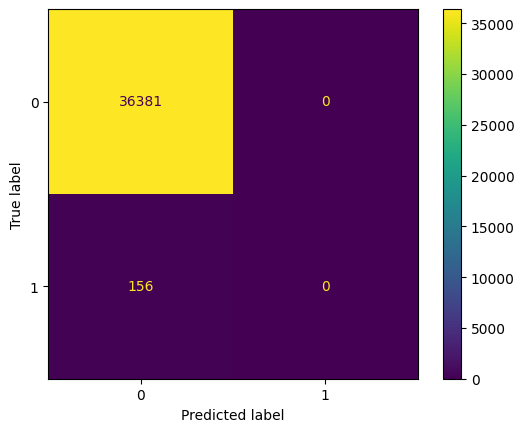

In [66]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

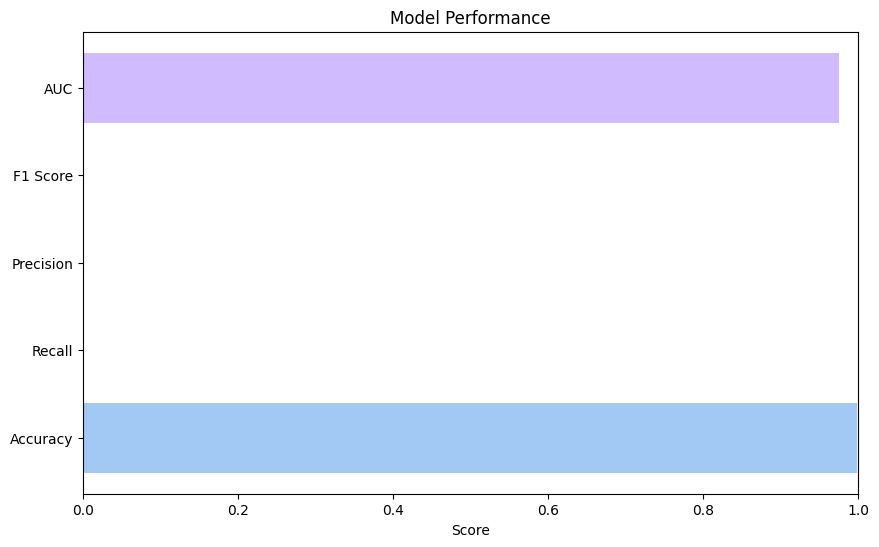

In [34]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [65]:
y_pred_b

array([0., 0., 0., ..., 0., 0., 0.])

In [70]:
from sklearn.metrics import precision_recall_curve, auc

# Compute precision and recall values
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate the area under the precision-recall curve (PRAUC)
prauc = auc(recall, precision)

print('PRAUC:', prauc)

ap = average_precision_score(y_test, y_pred)
print('average_precision_score', ap)

PRAUC: 0.29860690539113965
average_precision_score 0.30169886652556177


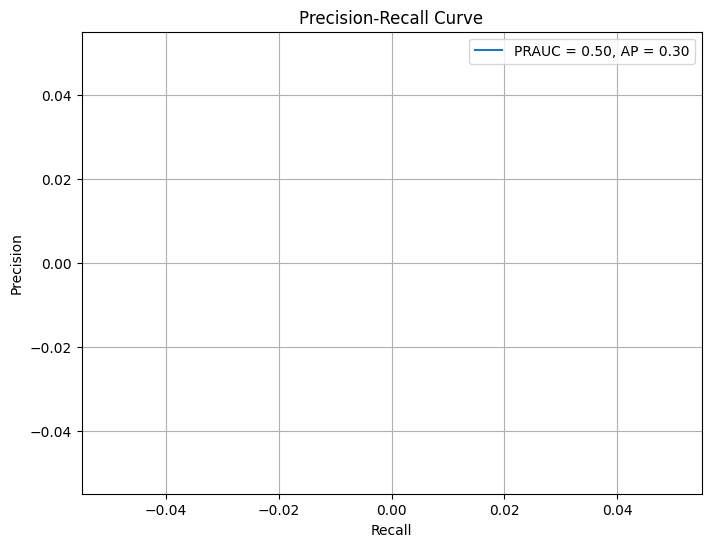

In [61]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [37]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
19          net_working_capital        4634
10                          m2b        3932
20                   debt_ratio        3456
32            price_to_earnings        3164
1                         STInt        3047
17                  quick_ratio        3031
2                      dtdlevel        3020
15              DTDmedianNonFin        3007
22                 equity_ratio        2987
28            days_in_inventory        2946
8                     sizelevel        2849
21         debt_to_equity_ratio        2800
25             return_on_assets        2741
6                    ni2talevel        2714
23       cashflow_to_debt_ratio        2697
3                      dtdtrend        2530
9                     sizetrend        2530
4                liqnonfinlevel        2434
5                liqnonfintrend        2432
31     working_capital_turnover        2406
26               asset_turnover        2328
18                   cash_ratio 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


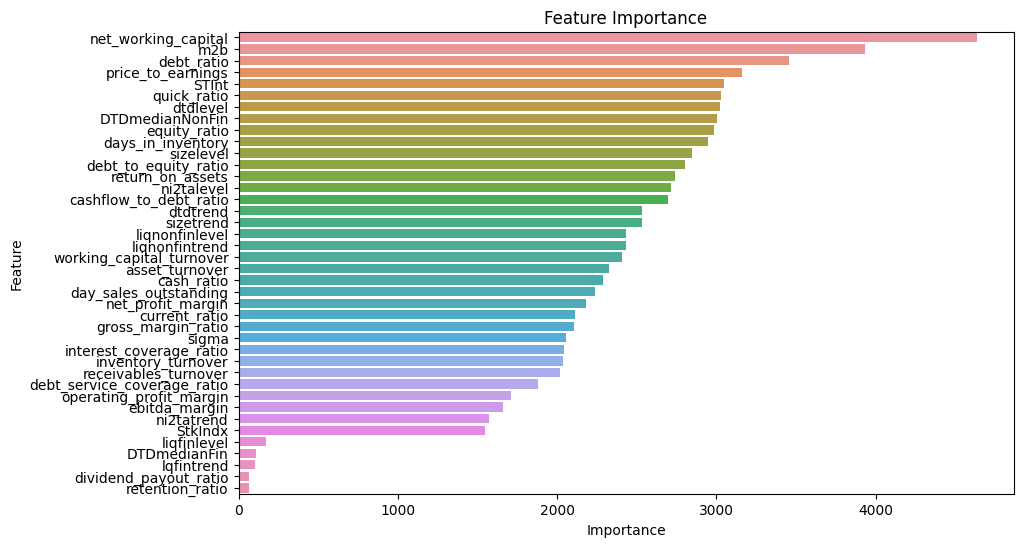

In [38]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

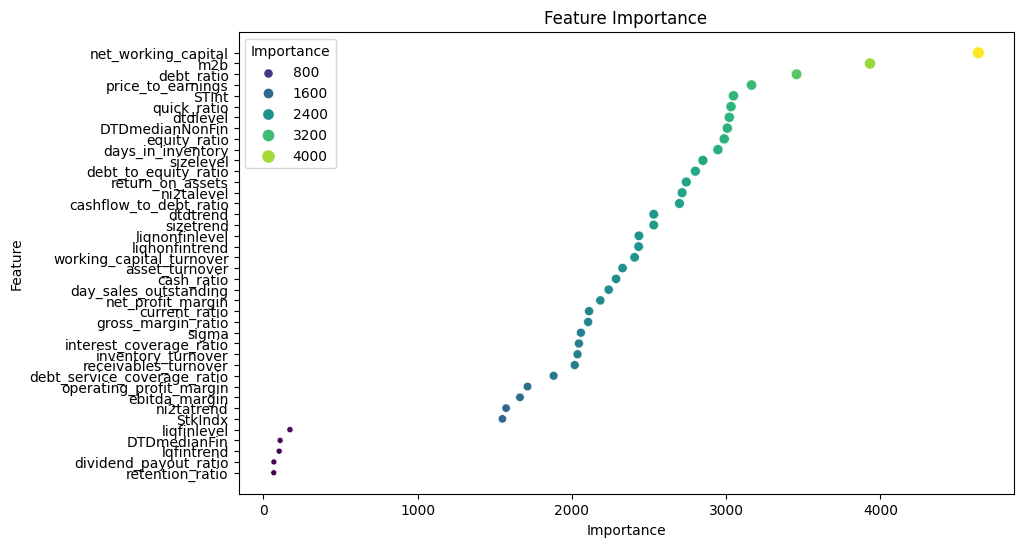

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

In [40]:
#Precision OPTIMIZED
results = pd.DataFrame({'Recall': [recall], 'Precision': [precision], 'F1 Score': [f1], 'AUC': [auc]})
results.to_csv('LGB_all_factors_results_aucoptimized.csv', index=False)

best_params_df = pd.DataFrame(best_params, index=[0])
best_params_df.to_csv('best_params_lgb_allfactorsaucoptimized.csv', index=False)

gbm.save_model('model_lgb_allfactorsaucoptimized.txt')

Load one model and Plot performances

In [46]:
path_to_model = path + "model_lgb_allfactors_aucoptimized.txt"
gbm = lgb.Booster(model_file=path_to_model)

y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

ConfusionMatrixDisplay(confusion).plot()

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: StartDate: object, EventDate: object, Duration: object, tic: object

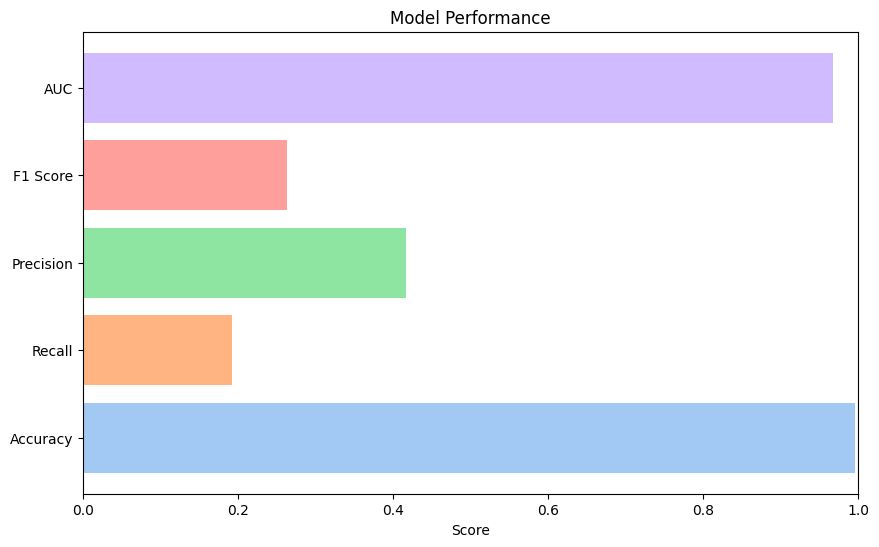

In [383]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [384]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
1                         STInt         756
19          net_working_capital         748
8                     sizelevel         728
22                 equity_ratio         724
29         receivables_turnover         700
20                   debt_ratio         685
4                liqnonfinlevel         656
26               asset_turnover         642
10                          m2b         631
17                  quick_ratio         611
35           gross_margin_ratio         608
30        day_sales_outstanding         592
2                      dtdlevel         584
27           inventory_turnover         577
16                current_ratio         568
6                    ni2talevel         561
15              DTDmedianNonFin         554
38  debt_service_coverage_ratio         539
23       cashflow_to_debt_ratio         536
39      interest_coverage_ratio         530
21         debt_to_equity_ratio         520
18                   cash_ratio 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


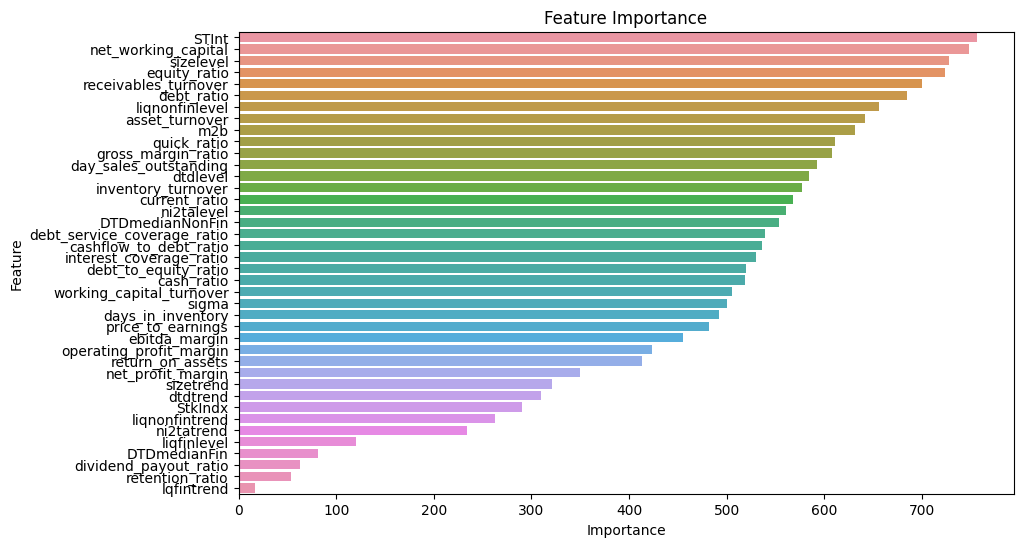

In [385]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

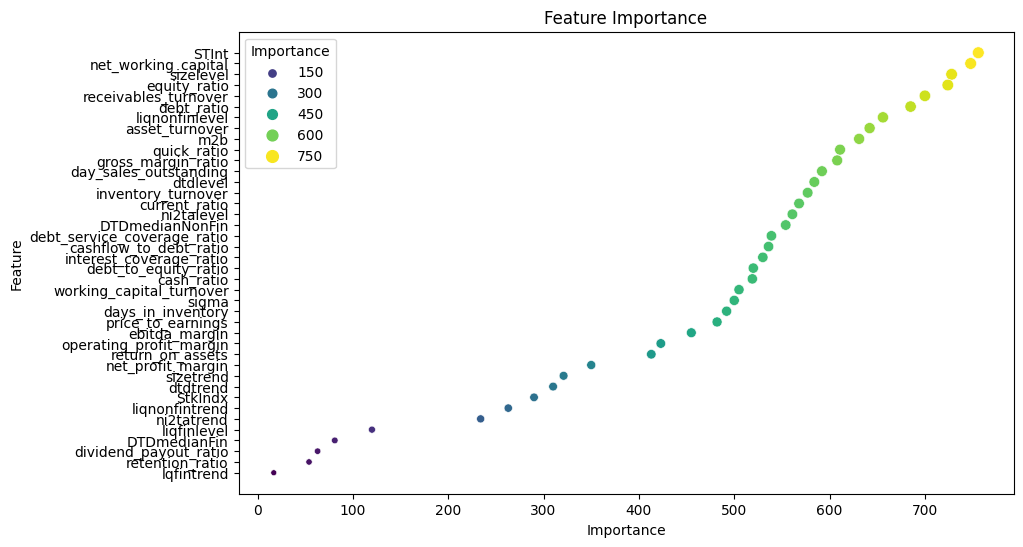

In [386]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

Load 3 models and compare performances


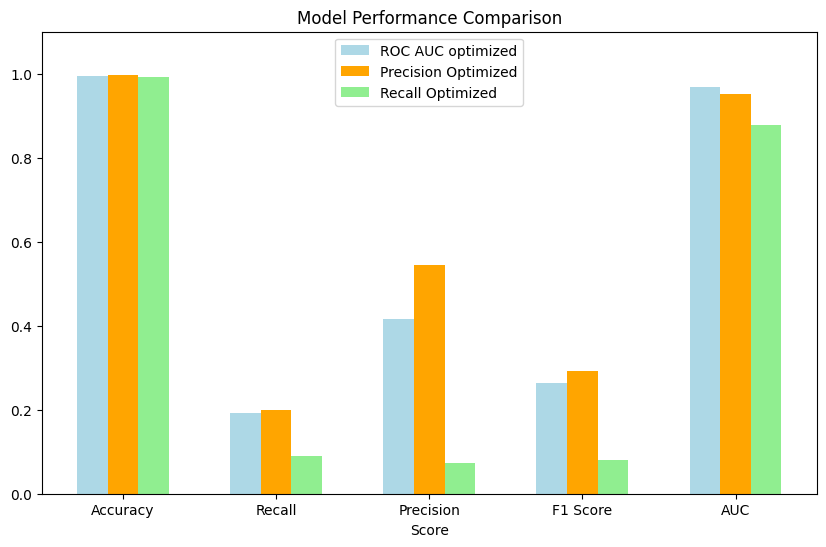

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

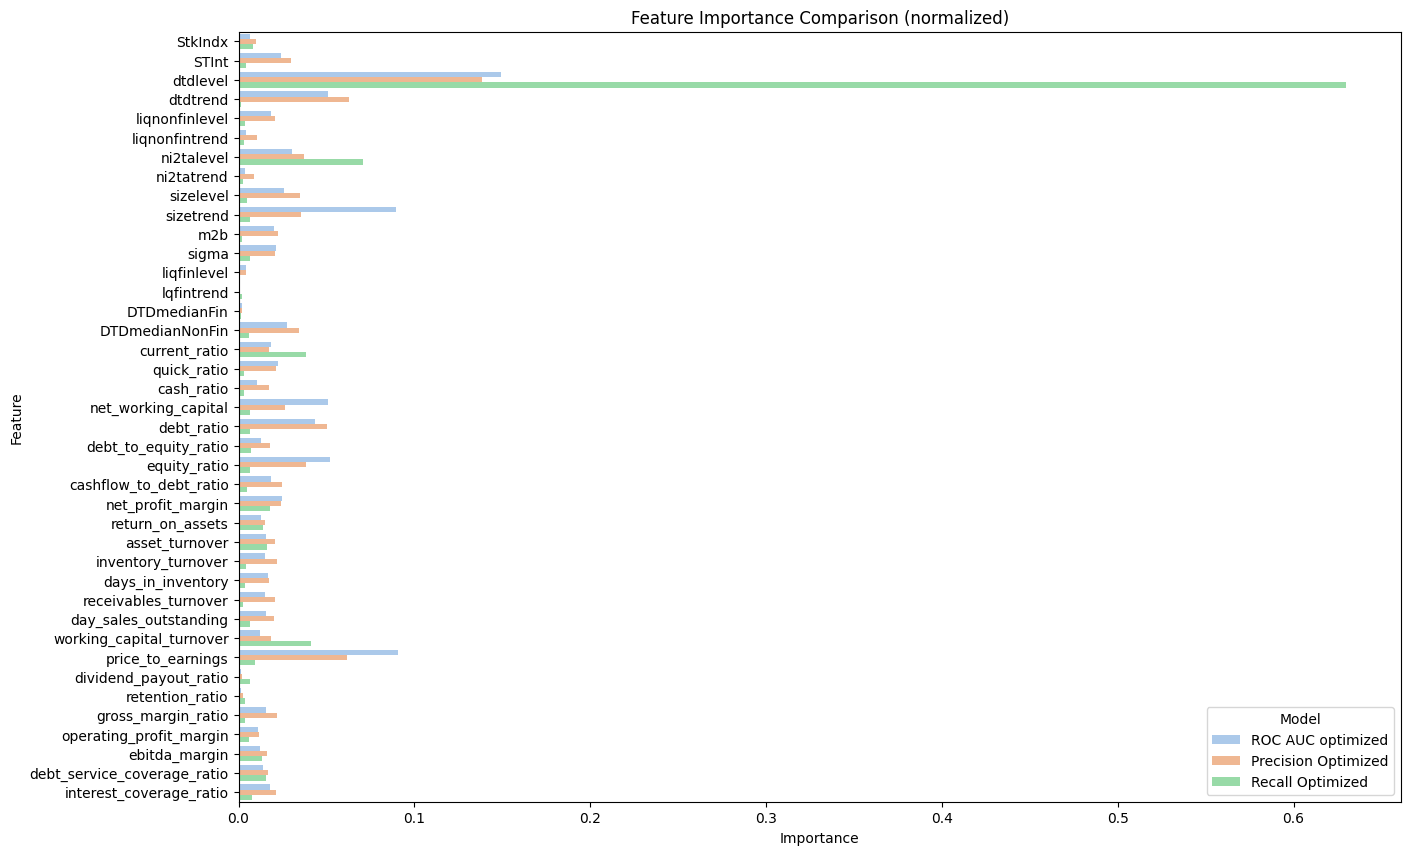

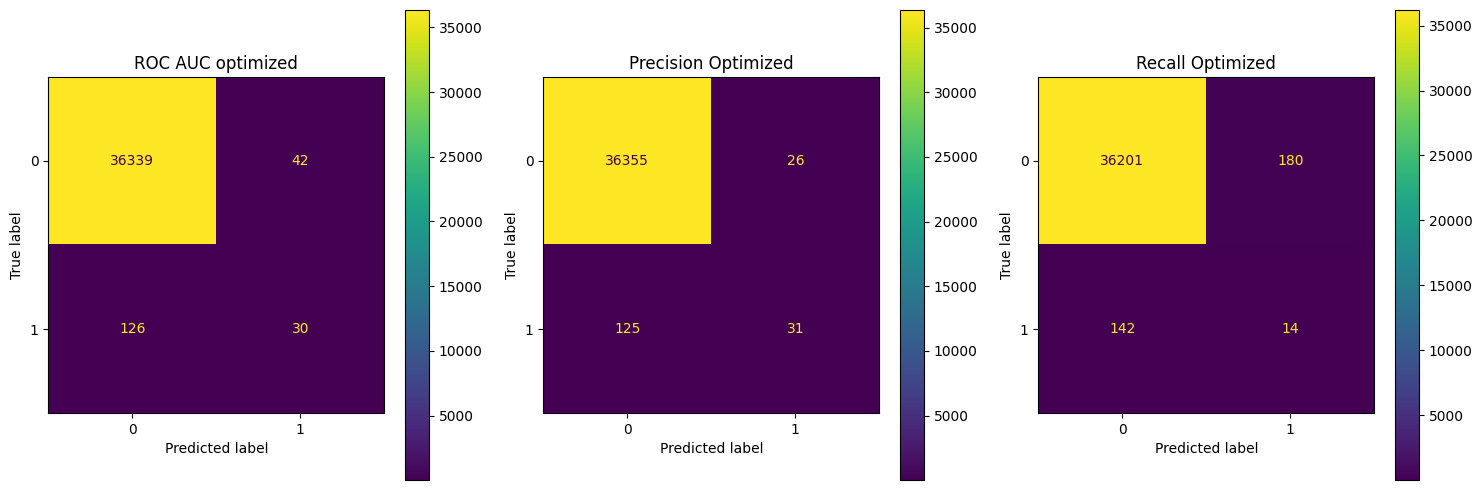

In [387]:
# Load the models
bst1 = lgb.Booster(model_file= path + 'model_lgb_allfactors_aucoptimized.txt')
bst2 = lgb.Booster(model_file= path + 'model_lgb_allfactors_precisionoptimized.txt')
bst3 = lgb.Booster(model_file= path + 'model_lgb_allfactors_recalloptimized.txt')

# Predict the test data
y_pred1 = bst1.predict(x_test)
y_pred2 = bst2.predict(x_test)
y_pred3 = bst3.predict(x_test)

# Calculate the metrics
accuracy1 = accuracy_score(y_test, np.round(y_pred1))
recall1 = recall_score(y_test, np.round(y_pred1))
precision1 = precision_score(y_test, np.round(y_pred1))
f1_1 = f1_score(y_test, np.round(y_pred1))
auc1 = roc_auc_score(y_test, y_pred1)

accuracy2 = accuracy_score(y_test, np.round(y_pred2))
recall2 = recall_score(y_test, np.round(y_pred2))
precision2 = precision_score(y_test, np.round(y_pred2))
f1_2 = f1_score(y_test, np.round(y_pred2))
auc2 = roc_auc_score(y_test, y_pred2)

accuracy3 = accuracy_score(y_test, np.round(y_pred3))
recall3 = recall_score(y_test, np.round(y_pred3))
precision3 = precision_score(y_test, np.round(y_pred3))
f1_3 = f1_score(y_test, np.round(y_pred3))
auc3 = roc_auc_score(y_test, y_pred3)

metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values1 = [accuracy1, recall1, precision1, f1_1, auc1]
values2 = [accuracy2, recall2, precision2, f1_2, auc2]
values3 = [accuracy3, recall3, precision3, f1_3, auc3]

x = np.arange(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, values1, 0.2, color='lightblue', label='ROC AUC optimized')
plt.bar(x, values2, 0.2, color='orange', label='Precision Optimized')
plt.bar(x + 0.2, values3, 0.2, color='lightgreen', label='Recall Optimized')
plt.xticks(x, metrics)
plt.xlabel('Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.1)
plt.legend()
plt.show()

importance1 = bst1.feature_importance(importance_type='gain')
importance2 = bst2.feature_importance(importance_type='gain')
importance3 = bst3.feature_importance(importance_type='gain')

# Normalize the feature importance
importance1 = importance1 / sum(importance1)
importance2 = importance2 / sum(importance2)
importance3 = importance3 / sum(importance3)

# # Plot the feature importance
importance_df = pd.DataFrame({'Feature': x_test.columns, 'ROC AUC optimized': importance1, 'Precision Optimized': importance2, 'Recall Optimized': importance3})

importance_df = importance_df.melt('Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', hue='Model', data=importance_df, palette='pastel')
plt.title('Feature Importance Comparison (normalized)')
plt.show()

# Calculate the confusion matrices
confusion1 = confusion_matrix(y_test, np.round(y_pred1))
confusion2 = confusion_matrix(y_test, np.round(y_pred2))
confusion3 = confusion_matrix(y_test, np.round(y_pred3))

# Plot the confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay(confusion1).plot(ax=axes[0], cmap='viridis')
axes[0].set_title('ROC AUC optimized')

ConfusionMatrixDisplay(confusion2).plot(ax=axes[1], cmap='viridis')
axes[1].set_title('Precision Optimized')

ConfusionMatrixDisplay(confusion3).plot(ax=axes[2], cmap='viridis')
axes[2].set_title('Recall Optimized')

plt.tight_layout()
plt.show()

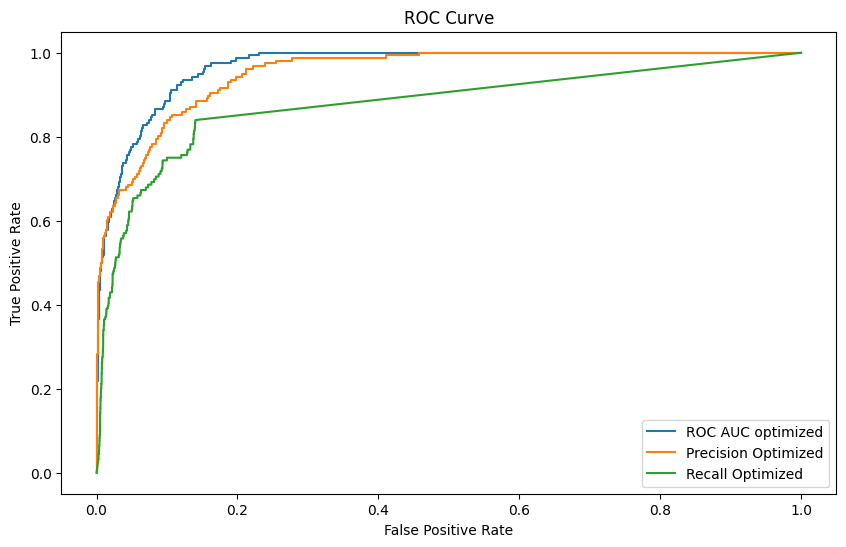

In [388]:
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
fpr3, tpr3, _ = roc_curve(y_test, y_pred3)

plt.figure(figsize=(10, 6))
plt.plot(fpr1, tpr1, label='ROC AUC optimized')
plt.plot(fpr2, tpr2, label='Precision Optimized')
plt.plot(fpr3, tpr3, label='Recall Optimized')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

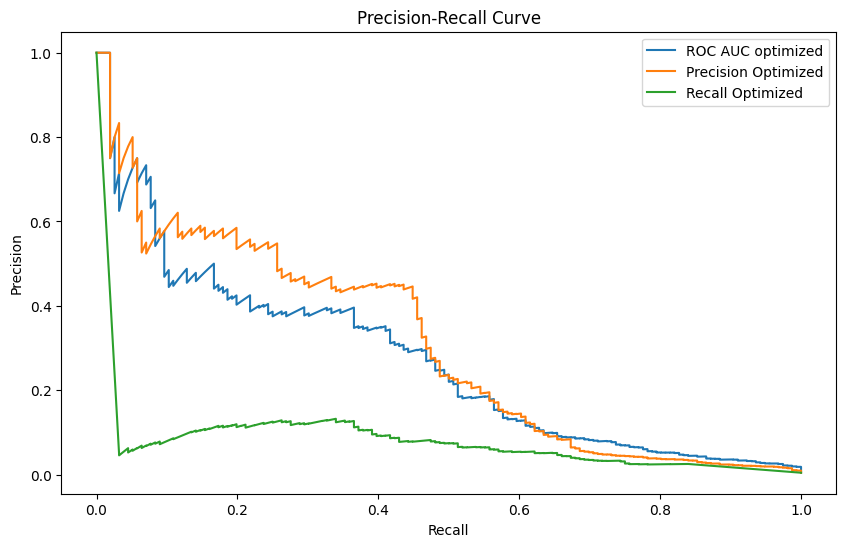

In [389]:
precision1, recall1, _ = precision_recall_curve(y_test, y_pred1)
precision2, recall2, _ = precision_recall_curve(y_test, y_pred2)
precision3, recall3, _ = precision_recall_curve(y_test, y_pred3)

plt.figure(figsize=(10, 6))
plt.plot(recall1, precision1, label='ROC AUC optimized')
plt.plot(recall2, precision2, label='Precision Optimized')
plt.plot(recall3, precision3, label='Recall Optimized')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Model l
Feature: 0
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 1
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 2
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 3
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 4
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 5
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 6
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 7
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 8
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 9
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7


c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

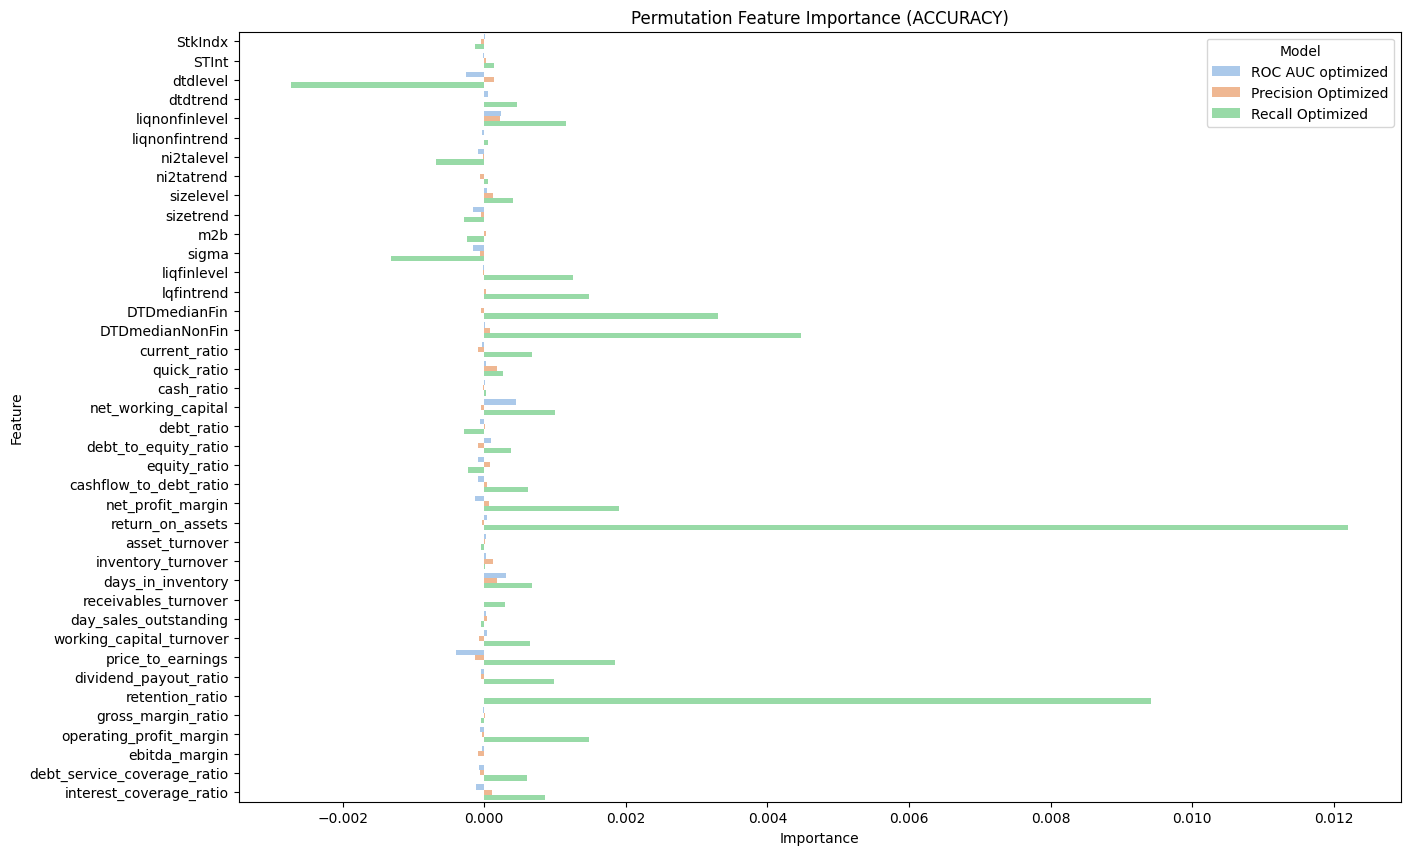

In [390]:
# BASED ON ACCURACY
def permutation_importance(model, X, y, scoring, n_repeats, random_state):
    baseline_score = scoring(y, np.round(model.predict(X)))
    scores = np.zeros((X.shape[1], n_repeats))
    rng = np.random.RandomState(random_state)
    
    for feature in range(X.shape[1]):
        print("Feature: " + str(feature))
        X_permuted = X.copy()
        for repeat in range(n_repeats):
            print("Repeat:" + str(repeat))
            X_permuted.iloc[:, feature] = rng.permutation(X_permuted.iloc[:, feature])
            score = scoring(y, np.round(model.predict(X_permuted)))
            scores[feature, repeat] = baseline_score - score
    
    return scores

print("Model l")
perm_importance1 = permutation_importance(bst1, x_test, y_test, accuracy_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance2 = permutation_importance(bst2, x_test, y_test, accuracy_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance3 = permutation_importance(bst3, x_test, y_test, accuracy_score, n_repeats=10, random_state=42)

perm_importance_df = pd.DataFrame({'Feature': x_test.columns, 'ROC AUC optimized': np.mean(perm_importance1, axis=1), 'Precision Optimized': np.mean(perm_importance2, axis=1), 'Recall Optimized': np.mean(perm_importance3, axis=1)})

perm_importance_df = perm_importance_df.melt('Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', hue='Model', data=perm_importance_df, palette='pastel')
plt.title('Permutation Feature Importance (ACCURACY)')
plt.show()

Model l
Model 3
Model 3


c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

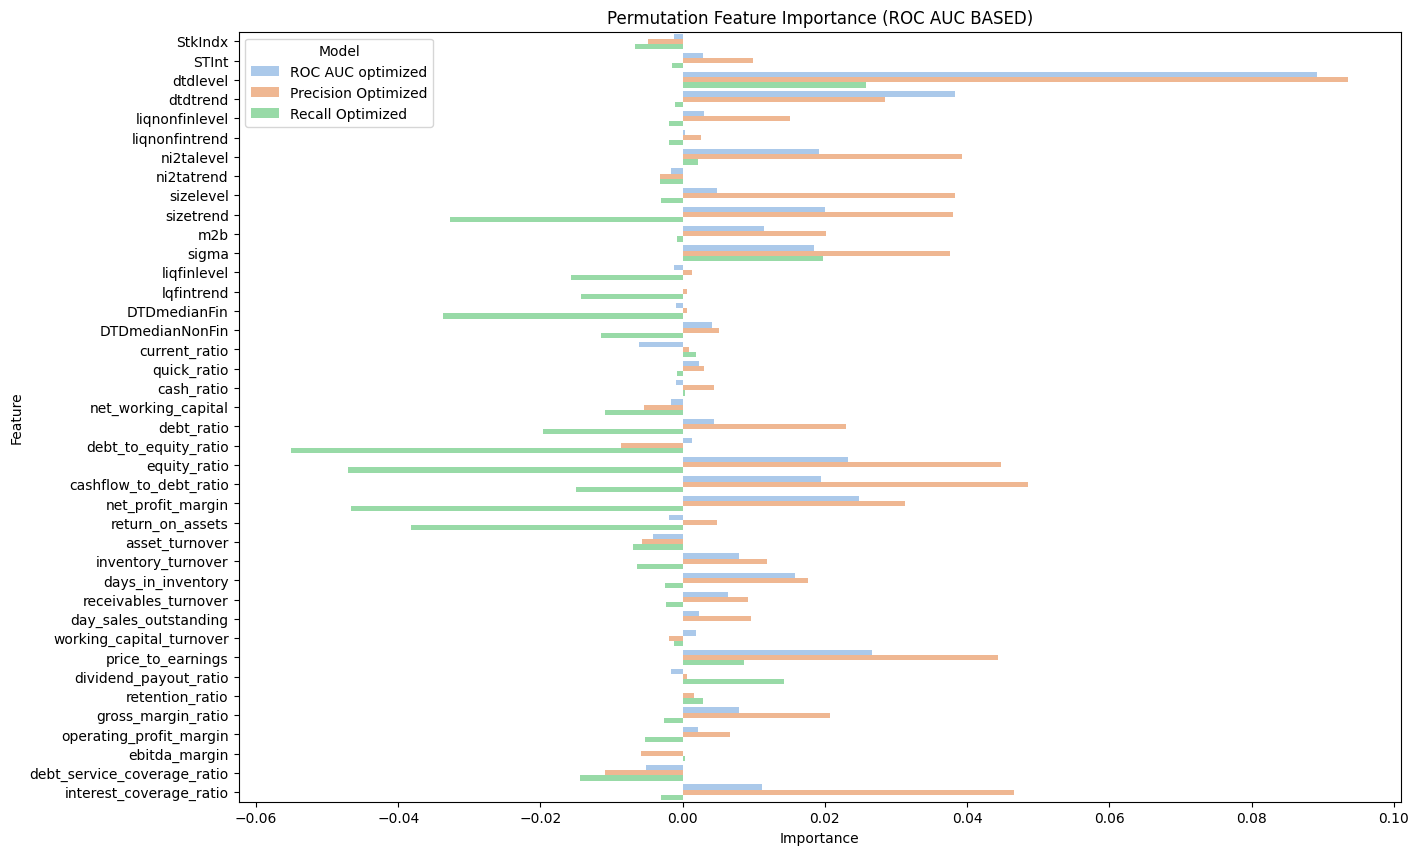

In [391]:
# BASED ON ROC AUC
def permutation_importance(model, X, y, scoring, n_repeats, random_state):
    baseline_score = scoring(y, np.round(model.predict(X)))
    scores = np.zeros((X.shape[1], n_repeats))
    rng = np.random.RandomState(random_state)
    
    for feature in range(X.shape[1]):
        X_permuted = X.copy()
        for repeat in range(n_repeats):
            X_permuted.iloc[:, feature] = rng.permutation(X_permuted.iloc[:, feature])
            score = scoring(y, np.round(model.predict(X_permuted)))
            scores[feature, repeat] = baseline_score - score
    
    return scores

print("Model l")
perm_importance1 = permutation_importance(bst1, x_test, y_test, roc_auc_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance2 = permutation_importance(bst2, x_test, y_test, roc_auc_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance3 = permutation_importance(bst3, x_test, y_test, roc_auc_score, n_repeats=10, random_state=42)

perm_importance_df = pd.DataFrame({'Feature': x_test.columns, 'ROC AUC optimized': np.mean(perm_importance1, axis=1), 'Precision Optimized': np.mean(perm_importance2, axis=1), 'Recall Optimized': np.mean(perm_importance3, axis=1)})

perm_importance_df = perm_importance_df.melt('Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', hue='Model', data=perm_importance_df, palette='pastel')
plt.title('Permutation Feature Importance (ROC AUC BASED)')
plt.show()